In [79]:
# from rubin_sim import maf
# from rubin_sim.data import get_data_dir

# try:
#     from rubin_sim.data import get_baseline
# except ImportError:
#     from rubin_scheduler.data import get_baseline
# import rubin_sim
# from rubin_sim import data
# from rubin_sim.data import get_baseline
import healpy as hp
import numpy as np
import sqlite3
from astropy.coordinates import SkyCoord
import astropy.units as u
import datashader as ds
import matplotlib.pyplot as plt
import matplotlib as mpl
from datashader.mpl_ext import dsshow
import pandas as pd
import galsim
import matplotlib.lines as mlines


def gaussian(x, mu=0, sigma=1, A=1):
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))


In [81]:
#Create some random data, multiple airmasses for each ra/dec position

ra_new = np.repeat(np.linspace(0, 180, 90), 50)
# np.random.shuffle(ra_new)
# dec_new = np.repeat(np.linspace(0, 80.0, 20),10))
dec_new = np.array([i for _ in range(50) for i in np.linspace(0, 50, 90)])
airmass_new = gaussian(dec_new, 25, 5, 2) + np.random.normal(0, 0.5, size = len(dec_new))

# ra_new
# dec_new

In [82]:
#making the resolution of the map, as well as the pixels in the form of an array
nside = 32
sentinel_value = 0
base_map = sentinel_value * np.ones(hp.nside2npix(nside))

#this part is talking about the actual pixel size
pix = hp.ang2pix(nside, ra_new, dec_new, lonlat=True, nest=True)
# pix

In [83]:
# so this creates an array of indeces that organizes the array(pix) in terms of their pixel number, 
# and then also as a tie-breaker sorts the pixels in terms of their airmass
sort_idx = np.lexsort((airmass_new, pix))
# pix[sort_idx]

In [84]:
# now we take all the different unique pixel values (i.e. total number of pixels)
# and obtain the u_idx_sorted which gives the first index that that pixel is referenced
# then counts_in_pix which states the number of visits was within that pixel/ times that pixel was mentioned
unique_pix, u_idx_sorted, counts_in_pix = np.unique(pix[sort_idx], return_index=True, return_counts=True)
# u_idx_sorted

In [85]:
#this defines what quartile in the airmass distribution of that pixel we want to be looking at

fraction = 0.75
#bin_centers is near the index that is at the value we want to see (i.e. at that specific airmass value)
bin_centers = u_idx_sorted + (counts_in_pix - 1) * (fraction) #Change depending on the value you're looking at

# bin_centers

In [86]:
#we round up and down the bin_centers obtain the actual index to obtain the range of the sorted airmass values
mids_low = airmass_new[sort_idx][np.floor(bin_centers).astype(int)]
mids_hi = airmass_new[sort_idx][np.ceil(bin_centers).astype(int)]
#average out the airmass value at those specific indeces
medians = (mids_low + mids_hi) * (1/2)

In [87]:
# map quartiles
median_gi_map = base_map.copy() #array of the number of pixels
median_gi_map[unique_pix] = medians

median_gi_map

array([ 0.        ,  0.57698351, -1.28386685, ...,  0.        ,
        0.        ,  0.        ], shape=(12288,))

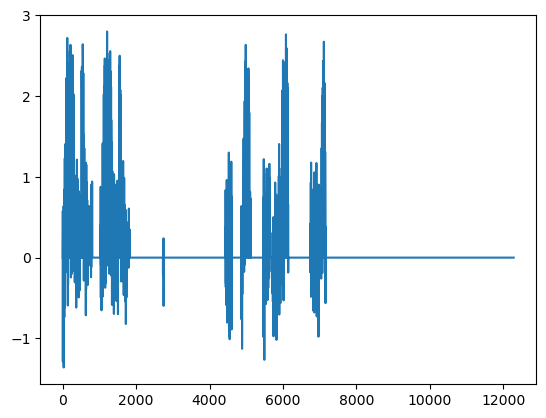

In [88]:
x = np.arange(len(median_gi_map))
plt.plot(x, median_gi_map)

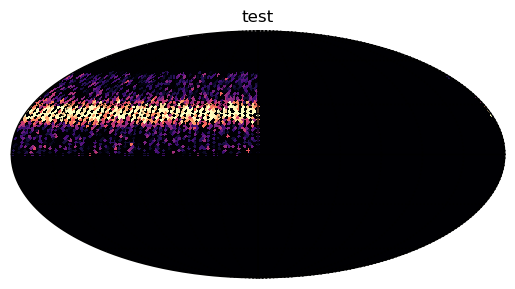

In [90]:
hp.mollview(median_gi_map, title=f"test", 
                    cmap='magma', cbar=False, nest=True, min=0, max=2, hold=True)
        
        # Add graticules
hp.graticule()